In [1]:
import pandas as pd 
# Load the dataset
df = pd.read_csv('cleaned_merged_data_final.csv')

# Ensure 'Time' is in datetime format
df['Time'] = pd.to_datetime(df['Time'])
df

,X,Y,Z,Time,Average_Heart_Rate,TEMP
0,-8.6499,-4.5781,0.187760,2016-04-12 00:00:00,61.48,31.17
1,-8.6275,-4.3198,0.023595,2016-04-12 00:01:00,64.02,31.17
2,-8.5055,-4.2772,0.275720,2016-04-12 00:02:00,64.16,31.17
3,-8.6279,-4.3163,0.367520,2016-04-12 00:03:00,64.08,31.17
4,-8.7008,-4.1459,0.407290,2016-04-12 00:04:00,63.89,31.17
...,...,...,...,...,...,...
44176,-2.4458,-10.0380,1.206400,2016-05-12 16:16:00,75.22,34.11
44177,-2.1038,-10.2980,1.224700,2016-05-12 16:17:00,74.25,34.11
44178,-2.5583,-9.7946,1.541500,2016-05-12 16:18:00,73.71,34.11
44179,-2.7153,-9.5697,2.031900,2016-05-12 16:19:00,75.50,34.11


In [2]:
# Obtenir les statistiques descriptives
df.describe()

,X,Y,Z,Time,Average_Heart_Rate,TEMP
count,44181.000000,44181.000000,44181.000000,44181,44181.000000,44181.000000
mean,-4.570160,-5.086597,2.618400,2016-04-27 08:10:00,74.341608,32.971941
min,-22.147000,-18.779000,-16.233000,2016-04-12 00:00:00,52.420000,31.170000
25%,-6.789700,-9.103300,0.813240,2016-04-19 16:05:00,66.180000,31.630000
50%,-3.977400,-7.342100,1.821200,2016-04-27 08:10:00,74.550000,33.890000
75%,-2.889000,0.764550,3.951900,2016-05-05 00:15:00,80.690000,34.150000
max,18.521000,17.382000,24.924000,2016-05-12 16:20:00,126.330000,34.660000
std,3.073662,5.615526,2.950329,NaN,10.477572,1.307903


In [3]:
count_above_105 = (df['Average_Heart_Rate'] > 105).sum()
count_above_105

408

In [5]:
import pandas as pd

df = pd.read_csv('cleaned_merged_data_final.csv')
df_cleaned = df[df['Average_Heart_Rate'] <= 104]

df_cleaned.to_csv('cleaned_data_heart_rate_below_105.csv', index=False)

In [6]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# 1. Charger et préparer les données
df = pd.read_csv('cleaned_data_heart_rate_below_105.csv')
df['Time'] = pd.to_datetime(df['Time'])

In [7]:
# 2. Créer des caractéristiques supplémentaires
df['Movement_Magnitude'] = np.sqrt(df['X']**2 + df['Y']**2 + df['Z']**2)
df['HR_Rolling_Mean'] = df['Average_Heart_Rate'].rolling(window=10, min_periods=1).mean()
df['HR_Rolling_Std'] = df['Average_Heart_Rate'].rolling(window=10, min_periods=1).std()
df['Movement_Rolling_Mean'] = df['Movement_Magnitude'].rolling(window=10, min_periods=1).mean()
df['Movement_Rolling_Std'] = df['Movement_Magnitude'].rolling(window=10, min_periods=1).std()

In [8]:
# Sélectionner les caractéristiques pour le modèle
features = ['X', 'Y', 'Z', 'Average_Heart_Rate', 'TEMP', 
            'Movement_Magnitude', 'HR_Rolling_Mean', 'HR_Rolling_Std',
            'Movement_Rolling_Mean', 'Movement_Rolling_Std']
X = df[features].dropna()

In [9]:
# 3. Normaliser les données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [10]:
# 4. Entraîner le modèle Isolation Forest
model = IsolationForest(contamination=0.01, random_state=42)
model.fit(X_scaled)


IsolationForest(contamination=0.01, random_state=42)

In [11]:
# Supprimer les lignes avec des valeurs manquantes et réinitialiser l'index
df = df.dropna().reset_index(drop=True)

In [12]:
# Préparer X pour le modèle
X = df[features]

In [13]:
# 3. Normaliser les données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [14]:

# 4. Entraîner le modèle Isolation Forest
model = IsolationForest(contamination=0.01, random_state=42)
model.fit(X_scaled)


IsolationForest(contamination=0.01, random_state=42)

In [15]:
# 5. Prédire sur les données d'entraînement
predictions = model.predict(X_scaled)
df['Anomaly'] = predictions
df['Anomaly'] = df['Anomaly'].map({1: 'Normal', -1: 'Anomaly'})

print("\nStatistiques du modèle:")
print(f"Nombre total d'observations: {len(df)}")
print(f"Nombre d'anomalies détectées: {(df['Anomaly'] == 'Anomaly').sum()}")


Statistiques du modèle:
Nombre total d'observations: 43676
Nombre d'anomalies détectées: 437


In [16]:
# 6. Créer des cas de test
# Cas normal
normal_case = pd.DataFrame({
    'X': [2.0], 'Y': [3.0], 'Z': [1.0],
    'Average_Heart_Rate': [70], 'TEMP': [31.5],
    'Movement_Magnitude': [np.sqrt(2.0**2 + 3.0**2 + 1.0**2)],
    'HR_Rolling_Mean': [72], 'HR_Rolling_Std': [3],
    'Movement_Rolling_Mean': [3.5], 'Movement_Rolling_Std': [0.5]
})

In [17]:
# Cas de blessure simulée
injury_case = pd.DataFrame({
    'X': [0.1], 'Y': [0.1], 'Z': [0.1],
    'Average_Heart_Rate': [120], 'TEMP': [33.5],
    'Movement_Magnitude': [np.sqrt(0.1**2 + 0.1**2 + 0.1**2)],
    'HR_Rolling_Mean': [115], 'HR_Rolling_Std': [10],
    'Movement_Rolling_Mean': [0.2], 'Movement_Rolling_Std': [0.05]
})

In [18]:
# Fonction de test
def test_case(case, case_name):
    case_scaled = scaler.transform(case[features])
    prediction = model.predict(case_scaled)
    result = 'Anomaly (Possible Injury)' if prediction[0] == -1 else 'Normal'
    print(f"\nRésultat pour {case_name}:")
    print(f"Prédiction: {result}")
    print("Valeurs:")
    for col in features:
        print(f"{col}: {case[col].values[0]:.2f}")
    return prediction[0]


Résultat pour Cas Normal:
Prédiction: Normal
Valeurs:
X: 2.00
Y: 3.00
Z: 1.00
Average_Heart_Rate: 70.00
TEMP: 31.50
Movement_Magnitude: 3.74
HR_Rolling_Mean: 72.00
HR_Rolling_Std: 3.00
Movement_Rolling_Mean: 3.50
Movement_Rolling_Std: 0.50

Résultat pour Cas de Blessure:
Prédiction: Anomaly (Possible Injury)
Valeurs:
X: 0.10
Y: 0.10
Z: 0.10
Average_Heart_Rate: 120.00
TEMP: 33.50
Movement_Magnitude: 0.17
HR_Rolling_Mean: 115.00
HR_Rolling_Std: 10.00
Movement_Rolling_Mean: 0.20
Movement_Rolling_Std: 0.05


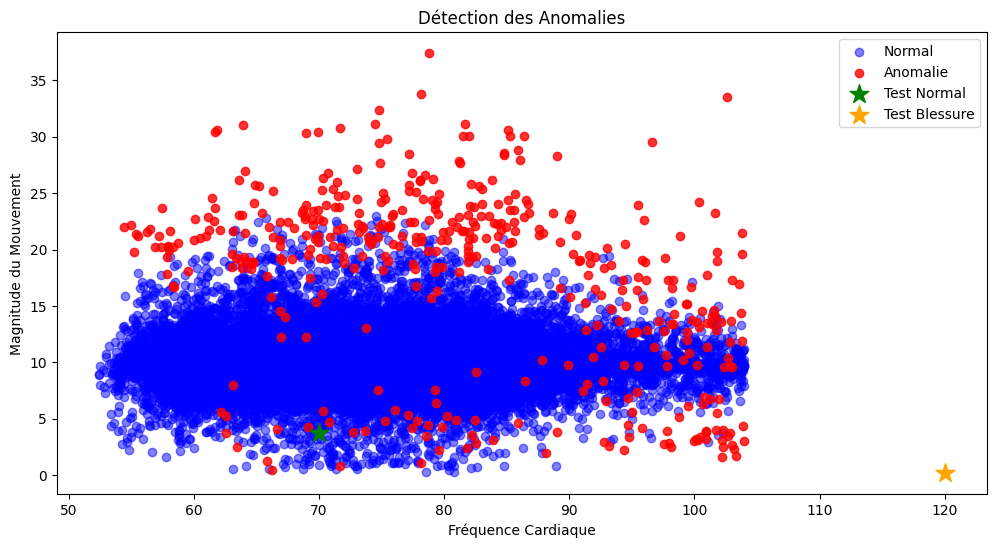

In [19]:
# Tester les deux cas
test_case(normal_case, "Cas Normal")
test_case(injury_case, "Cas de Blessure")

# Visualiser les résultats
plt.figure(figsize=(12, 6))
plt.scatter(df[df['Anomaly']=='Normal']['Average_Heart_Rate'], 
           df[df['Anomaly']=='Normal']['Movement_Magnitude'], 
           c='blue', label='Normal', alpha=0.5)
plt.scatter(df[df['Anomaly']=='Anomaly']['Average_Heart_Rate'], 
           df[df['Anomaly']=='Anomaly']['Movement_Magnitude'], 
           c='red', label='Anomalie', alpha=0.8)
plt.scatter(normal_case['Average_Heart_Rate'], normal_case['Movement_Magnitude'], 
           c='green', marker='*', s=200, label='Test Normal')
plt.scatter(injury_case['Average_Heart_Rate'], injury_case['Movement_Magnitude'], 
           c='orange', marker='*', s=200, label='Test Blessure')
plt.xlabel('Fréquence Cardiaque')
plt.ylabel('Magnitude du Mouvement')
plt.title('Détection des Anomalies')
plt.legend()
plt.show()

In [20]:
# Afficher les statistiques des données normales
print("\nStatistiques des données normales:")
print(df[df['Anomaly']=='Normal'][['Average_Heart_Rate', 'Movement_Magnitude']].describe())


Statistiques des données normales:
       Average_Heart_Rate  Movement_Magnitude
count        43239.000000        43239.000000
mean            73.876303            9.857151
std              9.804203            1.853671
min             52.420000            0.305982
25%             66.000000            9.500743
50%             74.380000            9.749329
75%             80.370000           10.079745
max            104.000000           23.012934


In [21]:
import joblib

# Enregistrer le modèle
joblib.dump(model, 'isolation_forest_model.joblib')

# Enregistrer le scaler
joblib.dump(scaler, 'scaler.joblib')

print("Modèle et scaler enregistrés avec succès.")

Modèle et scaler enregistrés avec succès.
